<a href="https://colab.research.google.com/github/aaanthonyyy/3020-project/blob/master/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import cv2
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow
import numpy as np
import os

# Component Detection

In [45]:
%cd dataset/circuits/
%ls


[Errno 2] No such file or directory: 'dataset/circuits/'
/home/imenko_prezimenovic/Desktop/fer/doas/DoasProj/dataset/circuits
20201127_135808.jpg  20210307_200951.jpg  20210311_144740.jpg
20210307_185350.jpg  20210307_200957.jpg  20210311_144802.jpg
20210307_185905.jpg  20210311_144631.jpg
20210307_200947.jpg  20210311_144643.jpg


In [191]:
# Set figure size to a tuple for (height, width)

FIG_SIZE = 20
FIG_SIZE = (FIG_SIZE,FIG_SIZE)

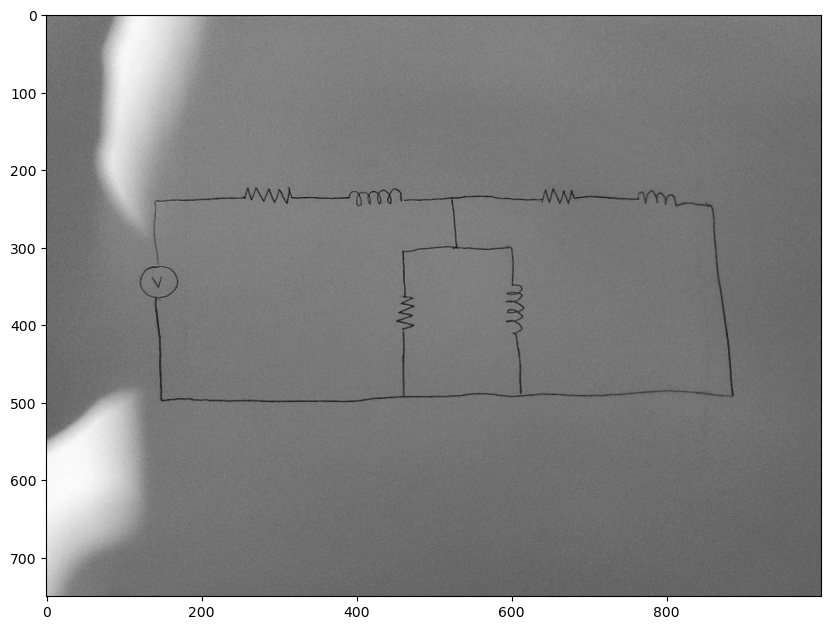

In [452]:
# display sample circuit schematic
img_raw = cv2.imread(os.listdir()[0])
img_raw = cv2.resize(img_raw, (1000, 750), interpolation=4)
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.show()

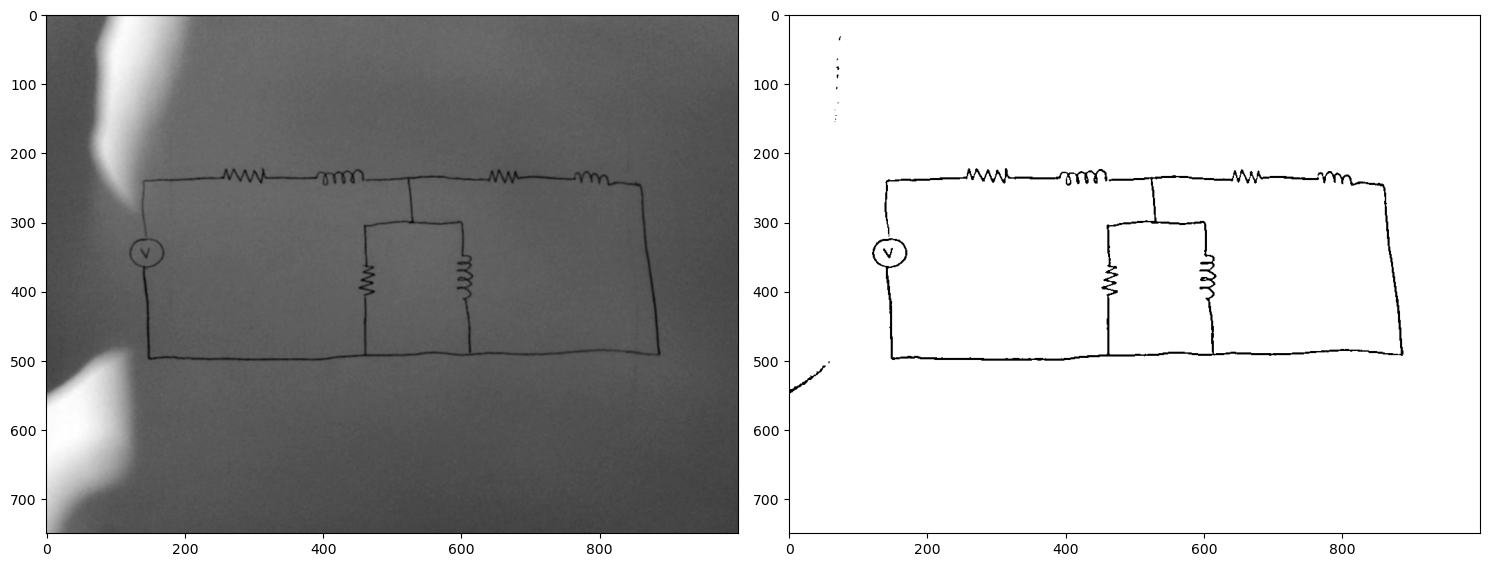

In [453]:
#@title Transformation Parameters { run: "auto" }

BLOCK = 27 #@param {type:"slider", min:1, max:27, step:2}
C = 10 #@param {type:"slider", min:0, max:30, step:1}

img = cv2.GaussianBlur(img,(5,5),0)

imgTres = cv2.adaptiveThreshold(img,255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY
                                ,BLOCK,C)

scale = 15

plt.figure(figsize=(1*scale,2*scale))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(imgTres, cmap='gray')

plt.tight_layout()

(-0.5, 999.5, 749.5, -0.5)

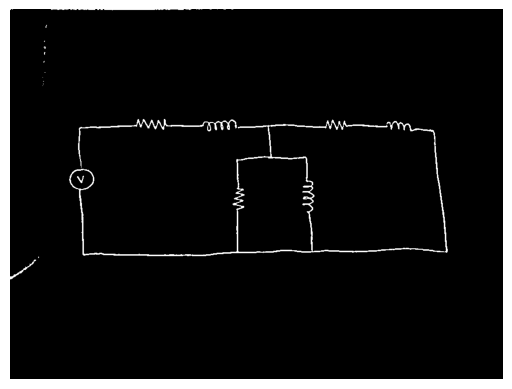

In [454]:
from pprint import pprint
img_tres = cv2.bitwise_not(imgTres)/255

plt.imshow(img_tres, 'gray')
plt.axis('off')

(-0.5, 999.5, 749.5, -0.5)

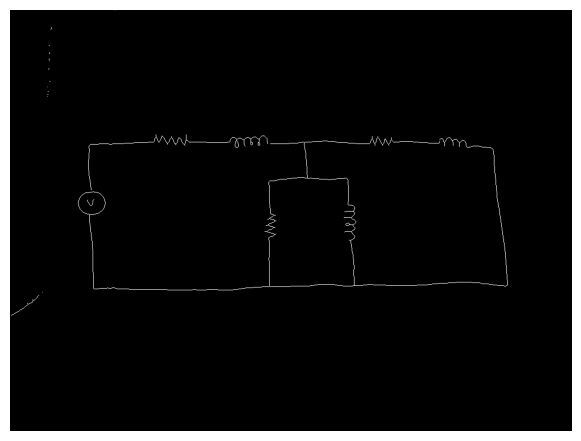

In [455]:
# perform morphological thinning to get 1px stroke

from skimage import io, color, morphology

imgSkel = morphology.skeletonize(img_tres)
imgThin = morphology.thin(imgTres < 0.5)

plt.imshow(imgSkel, cmap='gray')

plt.tight_layout()
plt.axis('off')

(-0.5, 999.5, 749.5, -0.5)

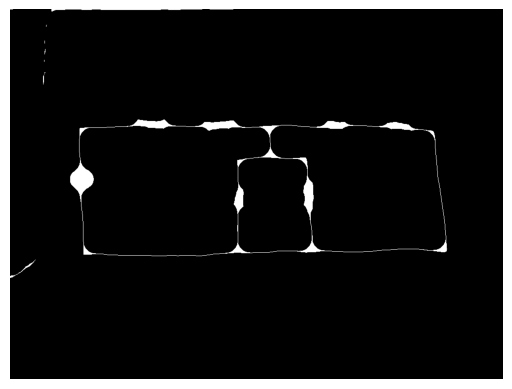

In [456]:
# morphological closing gives blobs around the components

CLOSE_SIZE = 64

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))

imgSkel.dtype = 'uint8'
img_close = cv2.bitwise_not(imgSkel)


img_close = np.copy(imgSkel)
img_close = cv2.morphologyEx(img_close, cv2.MORPH_CLOSE, kernel, iterations=1)

# plt.figure(figsize=FIG_SIZE)
plt.imshow(img_close, cmap='gray')
plt.axis('off')


(-0.5, 999.5, 749.5, -0.5)

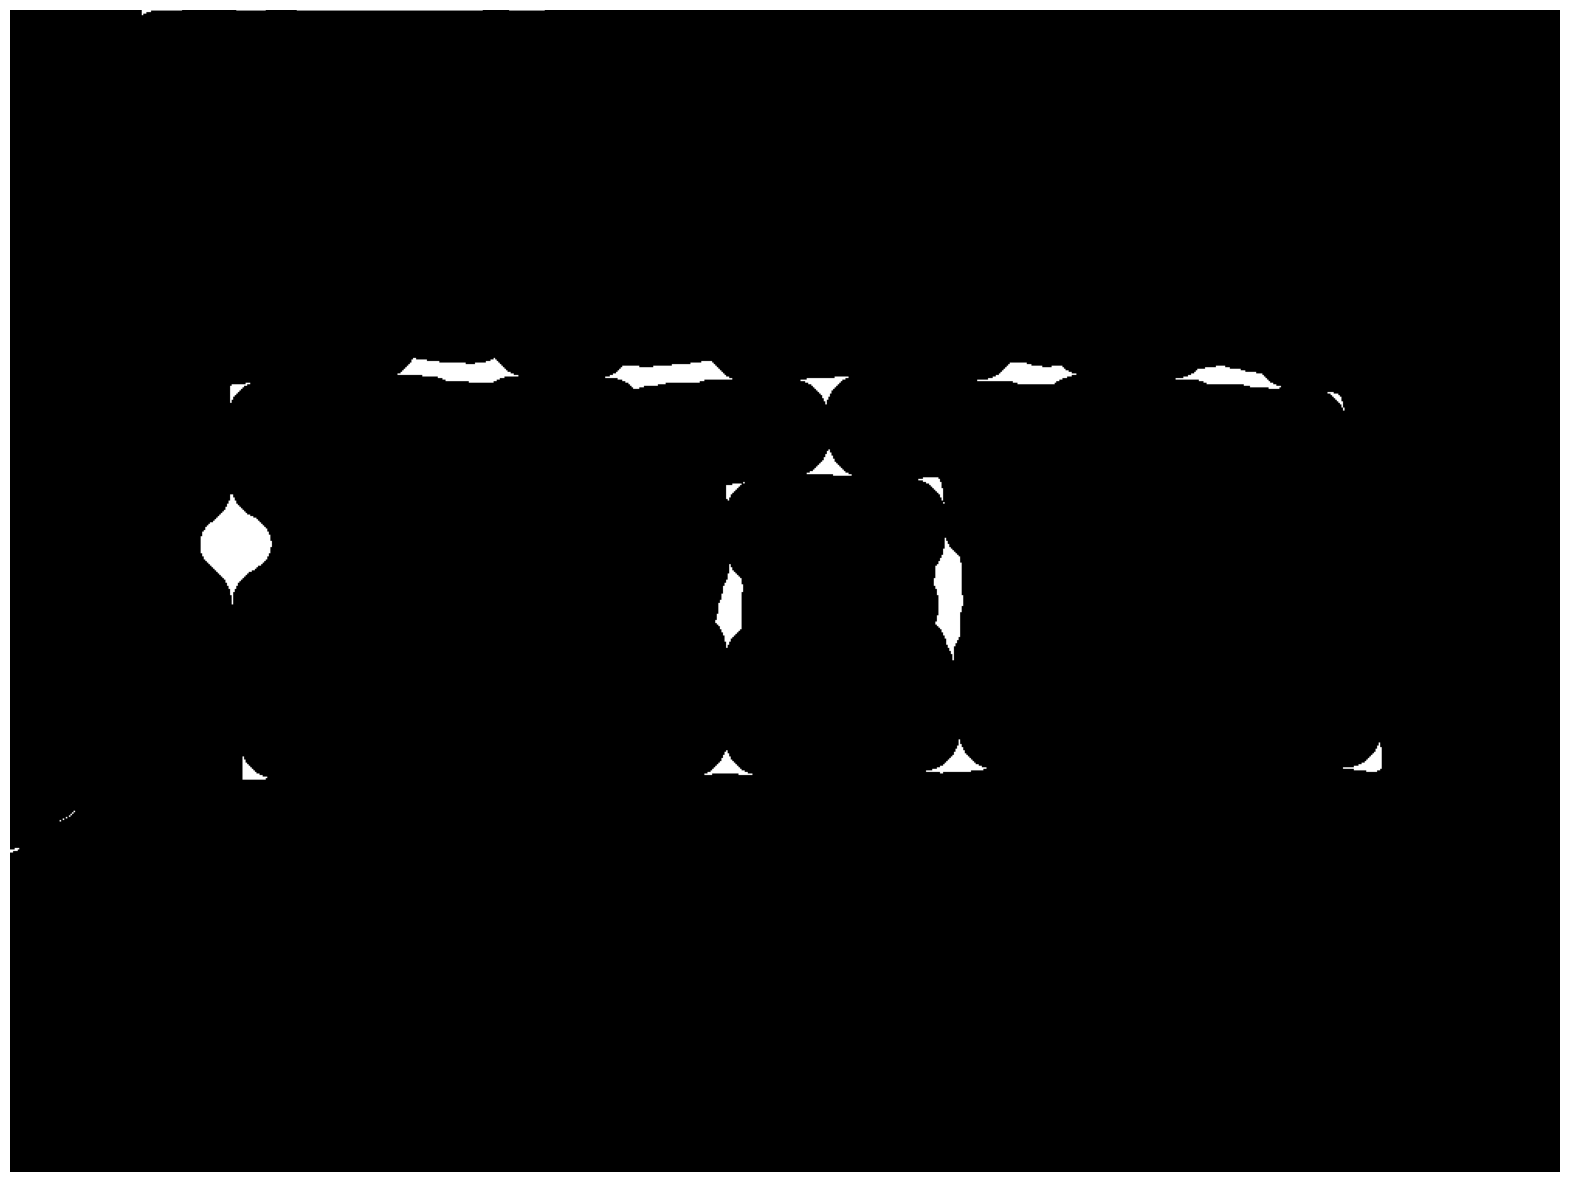

In [457]:
# morphological erosion used to erase connecting lines
# leaving just blobs

kernel = np.ones((3,3),np.uint8)
img_blob = cv2.erode(img_close,kernel,iterations = 1)

plt.figure(figsize=FIG_SIZE)
plt.imshow(img_blob, cmap='gray')
plt.axis("off")


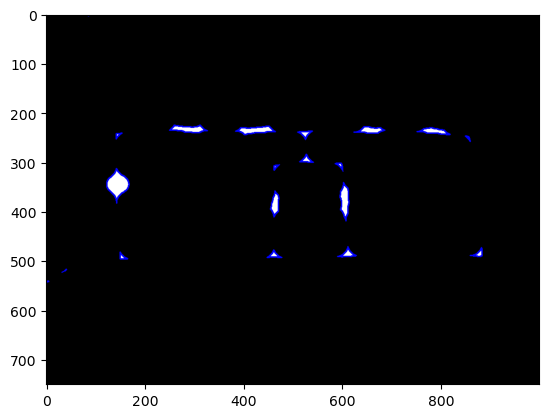

In [458]:
img_cont = img_raw.copy()

# contour detection
contours5, heirachy = cv2.findContours(img_blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_conts = np.zeros_like(img_raw)
img_conts = cv2.drawContours(cv2.cvtColor(img_blob*255, cv2.COLOR_GRAY2BGR), contours5, -1, (0,0,255), 2)

#cv2_imshow(img_conts)
plt.imshow(img_conts)

In [459]:
# draw bounding boxes around detection components (blobs)
# returns tuple of new image with boudning boxes, and component locations

def detect_components(img_raw):

    img_cont = img_raw.copy()

    # contour detection
    contours5, heirachy = cv2.findContours(img_blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    components = []

    for c in contours5:
        x, y, w, h = cv2.boundingRect(c)

        # threshold for 50x50 structuring element
        if(w > CLOSE_SIZE or h > CLOSE_SIZE):
            # only include if box meets this threshold
            components.append(np.array((y-10, h+20, x-10, w+20)))

            # rect = cv2.rectangle(img_cont, (x, y), (x + w, y + h), (0,255,0), 3)

    return components

In [460]:
# Used to draw bounding boxes and predictions on image
def draw_components(img_raw):

    img = img_raw.copy()

    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    except:
        pass

    components = detect_components(img)

    FONT_FACE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SCALE = 0.7
    COLOR = (0,255,0)


    for i in range(len(components)):
        y,h,x,w = components[i]

        h = y + h
        w = x + w
        y,h,x,w = max(0,y), max(0,h), max(0,x), max(0,w)
        if x >= w or y >= h:
            continue

        img_overlay = np.ones_like(img[y:h,x:w])*255

        # draw bounding-boxes around image
        # cv2.rectangle(img, (x, y), (w, h), COLOR, 2)

        cv2.rectangle(cv2.UMat(img_overlay), (0, 0), (w, h), (0, 255, 0), -1)
        cv2.rectangle(cv2.UMat(img), (x, y), (w, h), (0, 255, 0), 2)

        img[y:h,x:w] = cv2.addWeighted(img[y:h,x:w], 1, img_overlay, 0.1, 0)

        # add labels above bounding boxes
        cv2.putText(img, f'cmp', (x, y-12), FONT_FACE, FONT_SCALE, COLOR, 1)

    return img

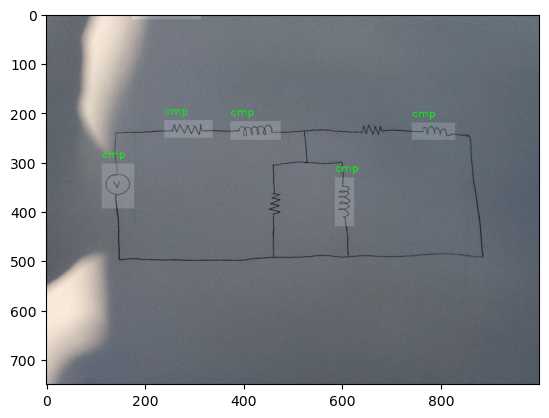

In [461]:
plt.imshow(draw_components(img_raw))